In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%pylab
%matplotlib inline
import os
import math
import time
import tensorflow as tf
from datasets import dataset_utils,cifar10
from tensorflow.contrib import slim

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
dropout_keep_prob=0.8
image_size = 32
step=20000
learning_rate=0.0002
train_dir = '/tmp/cifar10/5deep1'

In [3]:
cifar10_data_dir='/media/ramdisk/data/cifar10'

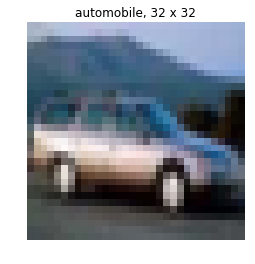

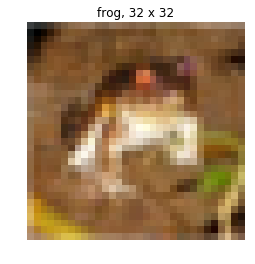

In [4]:
display_step=2

with tf.Graph().as_default(): 
    dataset = cifar10.get_split('train', cifar10_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])

    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(display_step):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()


In [5]:

def cnn_relu(images, num_classes, is_training):
    #https://github.com/agrawalnishant/tensorflow-1/tree/master/tensorflow/contrib/slim 
    ##vgg와  cifarndet을 참조함
    with slim.arg_scope([slim.max_pool2d], stride=2): 

        net = slim.repeat(images,2, slim.conv2d, 64, [3, 3], scope='conv1',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [7, 7], scope='conv2',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 4, slim.conv2d, 512, [5, 5], scope='conv4',activation_fn=tf.nn.relu)
        net = slim.max_pool2d(net, [2, 2], scope='pool4')

       
        net = slim.conv2d(net, 1024, [2, 2], padding="VALID", scope='fc6')
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                         scope='dropout6')
        net = slim.conv2d(net, 1024, [1, 1], scope='fc8', activation_fn=None)
        net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                           scope='dropout7')
        net = slim.conv2d(net, num_classes, [1, 1],
                          activation_fn=None,
                          normalizer_fn=None,
                          scope='fc9')
        
        net = tf.squeeze(net, [1,2],name='fc9/squeezed')
        
        return net

In [6]:
from preprocessing import cifarnet_preprocessing

def load_batch(dataset, batch_size=128, height=image_size, width=image_size, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=128,
        common_queue_min=32)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = cifarnet_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=4,
          capacity=4 * batch_size)
    
    return images, images_raw, labels

In [7]:
%%time
# This might take a few minutes.

print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = cifar10.get_split('train', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits =cnn_relu(images, num_classes=dataset.num_classes, is_training=True)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    
    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
    
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=step, 
          log_every_n_steps=10,
        save_interval_secs=100,
      save_summaries_secs=100)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/cifar10/5deep1
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/cifar10/5deep1/model.ckpt
INFO:tensorflow:

INFO:tensorflow:global step 810: loss = 1.2760 (0.162 sec/step)
INFO:tensorflow:global step 820: loss = 1.4222 (0.161 sec/step)
INFO:tensorflow:global step 830: loss = 1.1896 (0.162 sec/step)
INFO:tensorflow:global step 840: loss = 1.0350 (0.160 sec/step)
INFO:tensorflow:global step 850: loss = 1.2121 (0.177 sec/step)
INFO:tensorflow:global step 860: loss = 1.0494 (0.167 sec/step)
INFO:tensorflow:global step 870: loss = 1.1095 (0.165 sec/step)
INFO:tensorflow:global step 880: loss = 1.0968 (0.170 sec/step)
INFO:tensorflow:global step 890: loss = 1.0212 (0.174 sec/step)
INFO:tensorflow:global step 900: loss = 0.9675 (0.170 sec/step)
INFO:tensorflow:global step 910: loss = 1.1992 (0.172 sec/step)
INFO:tensorflow:global step 920: loss = 1.1242 (0.159 sec/step)
INFO:tensorflow:global step 930: loss = 1.0540 (0.166 sec/step)
INFO:tensorflow:global step 940: loss = 1.0763 (0.157 sec/step)
INFO:tensorflow:global step 950: loss = 1.1151 (0.165 sec/step)
INFO:tensorflow:global step 960: loss = 

INFO:tensorflow:global step 2030: loss = 0.6897 (0.163 sec/step)
INFO:tensorflow:global step 2040: loss = 0.6147 (0.174 sec/step)
INFO:tensorflow:global step 2050: loss = 0.5924 (0.161 sec/step)
INFO:tensorflow:global step 2060: loss = 0.5764 (0.151 sec/step)
INFO:tensorflow:global step 2070: loss = 0.5799 (0.161 sec/step)
INFO:tensorflow:global step 2080: loss = 0.6216 (0.161 sec/step)
INFO:tensorflow:global step 2090: loss = 0.5242 (0.161 sec/step)
INFO:tensorflow:global step 2100: loss = 0.4699 (0.157 sec/step)
INFO:tensorflow:global step 2110: loss = 0.4240 (0.168 sec/step)
INFO:tensorflow:global step 2120: loss = 0.4814 (0.172 sec/step)
INFO:tensorflow:global step 2130: loss = 0.5699 (0.164 sec/step)
INFO:tensorflow:global step 2140: loss = 0.4886 (0.155 sec/step)
INFO:tensorflow:global step 2150: loss = 0.5714 (0.163 sec/step)
INFO:tensorflow:global step 2160: loss = 0.6901 (0.158 sec/step)
INFO:tensorflow:global step 2170: loss = 0.3959 (0.164 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 3250: loss = 0.3990 (0.165 sec/step)
INFO:tensorflow:global step 3260: loss = 0.4028 (0.162 sec/step)
INFO:tensorflow:global step 3270: loss = 0.3069 (0.159 sec/step)
INFO:tensorflow:global step 3280: loss = 0.2454 (0.159 sec/step)
INFO:tensorflow:global step 3290: loss = 0.2616 (0.164 sec/step)
INFO:tensorflow:global step 3300: loss = 0.3008 (0.152 sec/step)
INFO:tensorflow:global step 3310: loss = 0.3279 (0.170 sec/step)
INFO:tensorflow:global step 3320: loss = 0.3971 (0.157 sec/step)
INFO:tensorflow:global step 3330: loss = 0.4209 (0.167 sec/step)
INFO:tensorflow:global step 3340: loss = 0.4563 (0.175 sec/step)
INFO:tensorflow:global step 3350: loss = 0.2562 (0.153 sec/step)
INFO:tensorflow:global step 3360: loss = 0.3640 (0.170 sec/step)
INFO:tensorflow:global step 3370: loss = 0.2988 (0.158 sec/step)
INFO:tensorflow:global step 3380: loss = 0.2707 (0.162 sec/step)
INFO:tensorflow:global step 3390: loss = 0.3759 (0.159 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 4470: loss = 0.1482 (0.171 sec/step)
INFO:tensorflow:global step 4480: loss = 0.2832 (0.149 sec/step)
INFO:tensorflow:global step 4490: loss = 0.2118 (0.177 sec/step)
INFO:tensorflow:global step 4500: loss = 0.1806 (0.152 sec/step)
INFO:tensorflow:global step 4510: loss = 0.2311 (0.161 sec/step)
INFO:tensorflow:global step 4520: loss = 0.1408 (0.173 sec/step)
INFO:tensorflow:global step 4530: loss = 0.1803 (0.157 sec/step)
INFO:tensorflow:global step 4540: loss = 0.2394 (0.153 sec/step)
INFO:tensorflow:global step 4550: loss = 0.1812 (0.171 sec/step)
INFO:tensorflow:global step 4560: loss = 0.1687 (0.160 sec/step)
INFO:tensorflow:global step 4570: loss = 0.1003 (0.158 sec/step)
INFO:tensorflow:global step 4580: loss = 0.1156 (0.154 sec/step)
INFO:tensorflow:global step 4590: loss = 0.0889 (0.172 sec/step)
INFO:tensorflow:global step 4600: loss = 0.1756 (0.154 sec/step)
INFO:tensorflow:global step 4610: loss = 0.2366 (0.155 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 5690: loss = 0.1749 (0.170 sec/step)
INFO:tensorflow:global step 5700: loss = 0.3088 (0.164 sec/step)
INFO:tensorflow:global step 5710: loss = 0.1159 (0.166 sec/step)
INFO:tensorflow:global step 5720: loss = 0.0833 (0.162 sec/step)
INFO:tensorflow:global step 5730: loss = 0.0649 (0.151 sec/step)
INFO:tensorflow:global step 5740: loss = 0.0395 (0.177 sec/step)
INFO:tensorflow:global step 5750: loss = 0.0910 (0.157 sec/step)
INFO:tensorflow:global step 5760: loss = 0.0584 (0.151 sec/step)
INFO:tensorflow:global step 5770: loss = 0.1149 (0.160 sec/step)
INFO:tensorflow:global step 5780: loss = 0.1379 (0.173 sec/step)
INFO:tensorflow:global step 5790: loss = 0.1713 (0.165 sec/step)
INFO:tensorflow:global step 5800: loss = 0.1680 (0.160 sec/step)
INFO:tensorflow:global step 5810: loss = 0.2675 (0.178 sec/step)
INFO:tensorflow:global step 5820: loss = 0.1627 (0.177 sec/step)
INFO:tensorflow:global step 5830: loss = 0.0678 (0.179 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 6920: loss = 0.1511 (0.163 sec/step)
INFO:tensorflow:global step 6930: loss = 0.0880 (0.163 sec/step)
INFO:tensorflow:global step 6940: loss = 0.1167 (0.162 sec/step)
INFO:tensorflow:global step 6950: loss = 0.1258 (0.154 sec/step)
INFO:tensorflow:global step 6960: loss = 0.1281 (0.157 sec/step)
INFO:tensorflow:global step 6970: loss = 0.1249 (0.175 sec/step)
INFO:tensorflow:global step 6980: loss = 0.0699 (0.164 sec/step)
INFO:tensorflow:global step 6990: loss = 0.1863 (0.183 sec/step)
INFO:tensorflow:global step 7000: loss = 0.0733 (0.167 sec/step)
INFO:tensorflow:global step 7010: loss = 0.0994 (0.164 sec/step)
INFO:tensorflow:global step 7020: loss = 0.1185 (0.158 sec/step)
INFO:tensorflow:global step 7030: loss = 0.0527 (0.154 sec/step)
INFO:tensorflow:global step 7040: loss = 0.0527 (0.159 sec/step)
INFO:tensorflow:global step 7050: loss = 0.0737 (0.159 sec/step)
INFO:tensorflow:global step 7060: loss = 0.0694 (0.158 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 8150: loss = 0.0341 (0.157 sec/step)
INFO:tensorflow:global step 8160: loss = 0.0496 (0.162 sec/step)
INFO:tensorflow:global step 8170: loss = 0.0280 (0.196 sec/step)
INFO:tensorflow:global step 8180: loss = 0.0788 (0.165 sec/step)
INFO:tensorflow:global step 8190: loss = 0.1041 (0.164 sec/step)
INFO:tensorflow:global step 8200: loss = 0.0320 (0.169 sec/step)
INFO:tensorflow:global step 8210: loss = 0.1569 (0.164 sec/step)
INFO:tensorflow:global step 8220: loss = 0.0721 (0.157 sec/step)
INFO:tensorflow:global step 8230: loss = 0.0282 (0.155 sec/step)
INFO:tensorflow:global step 8240: loss = 0.1255 (0.167 sec/step)
INFO:tensorflow:global step 8250: loss = 0.0139 (0.157 sec/step)
INFO:tensorflow:global step 8260: loss = 0.1137 (0.157 sec/step)
INFO:tensorflow:global step 8270: loss = 0.1269 (0.173 sec/step)
INFO:tensorflow:global step 8280: loss = 0.0432 (0.170 sec/step)
INFO:tensorflow:global step 8290: loss = 0.0332 (0.155 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 9380: loss = 0.0398 (0.162 sec/step)
INFO:tensorflow:global step 9390: loss = 0.0233 (0.156 sec/step)
INFO:tensorflow:global step 9400: loss = 0.0383 (0.163 sec/step)
INFO:tensorflow:global step 9410: loss = 0.0563 (0.166 sec/step)
INFO:tensorflow:global step 9420: loss = 0.1022 (0.160 sec/step)
INFO:tensorflow:global step 9430: loss = 0.1282 (0.150 sec/step)
INFO:tensorflow:global step 9440: loss = 0.0162 (0.166 sec/step)
INFO:tensorflow:global step 9450: loss = 0.0285 (0.168 sec/step)
INFO:tensorflow:global step 9460: loss = 0.0813 (0.160 sec/step)
INFO:tensorflow:global step 9470: loss = 0.0196 (0.163 sec/step)
INFO:tensorflow:global step 9480: loss = 0.0360 (0.168 sec/step)
INFO:tensorflow:global step 9490: loss = 0.0788 (0.154 sec/step)
INFO:tensorflow:global step 9500: loss = 0.0268 (0.174 sec/step)
INFO:tensorflow:global step 9510: loss = 0.0684 (0.169 sec/step)
INFO:tensorflow:global step 9520: loss = 0.0374 (0.167 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 10600: loss = 0.0495 (0.169 sec/step)
INFO:tensorflow:global step 10610: loss = 0.0688 (0.184 sec/step)
INFO:tensorflow:global step 10620: loss = 0.0124 (0.167 sec/step)
INFO:tensorflow:global step 10630: loss = 0.0125 (0.170 sec/step)
INFO:tensorflow:global step 10640: loss = 0.0698 (0.154 sec/step)
INFO:tensorflow:global step 10650: loss = 0.0574 (0.178 sec/step)
INFO:tensorflow:global step 10660: loss = 0.0529 (0.168 sec/step)
INFO:tensorflow:global step 10670: loss = 0.0163 (0.180 sec/step)
INFO:tensorflow:global step 10680: loss = 0.0377 (0.151 sec/step)
INFO:tensorflow:global step 10690: loss = 0.0450 (0.163 sec/step)
INFO:tensorflow:global step 10700: loss = 0.1038 (0.165 sec/step)
INFO:tensorflow:global step 10710: loss = 0.0924 (0.152 sec/step)
INFO:tensorflow:global step 10720: loss = 0.0312 (0.158 sec/step)
INFO:tensorflow:global step 10730: loss = 0.0265 (0.164 sec/step)
INFO:tensorflow:global step 10740: loss = 0.0535 (0.164 sec/step)
INFO:tenso

INFO:tensorflow:global step 11810: loss = 0.0372 (0.158 sec/step)
INFO:tensorflow:global step 11820: loss = 0.0309 (0.159 sec/step)
INFO:tensorflow:global step 11830: loss = 0.0659 (0.154 sec/step)
INFO:tensorflow:global step 11840: loss = 0.0243 (0.158 sec/step)
INFO:tensorflow:global step 11850: loss = 0.0404 (0.169 sec/step)
INFO:tensorflow:global step 11860: loss = 0.0256 (0.163 sec/step)
INFO:tensorflow:global step 11870: loss = 0.0373 (0.169 sec/step)
INFO:tensorflow:global step 11880: loss = 0.0164 (0.167 sec/step)
INFO:tensorflow:global step 11890: loss = 0.1118 (0.167 sec/step)
INFO:tensorflow:global step 11900: loss = 0.1065 (0.170 sec/step)
INFO:tensorflow:global step 11910: loss = 0.1046 (0.165 sec/step)
INFO:tensorflow:global step 11920: loss = 0.0498 (0.177 sec/step)
INFO:tensorflow:global step 11930: loss = 0.1260 (0.158 sec/step)
INFO:tensorflow:global step 11940: loss = 0.0253 (0.156 sec/step)
INFO:tensorflow:global step 11950: loss = 0.0334 (0.163 sec/step)
INFO:tenso

INFO:tensorflow:global step 13020: loss = 0.0753 (0.183 sec/step)
INFO:tensorflow:global step 13030: loss = 0.0520 (0.163 sec/step)
INFO:tensorflow:global step 13040: loss = 0.0245 (0.182 sec/step)
INFO:tensorflow:global step 13050: loss = 0.0174 (0.165 sec/step)
INFO:tensorflow:global step 13060: loss = 0.0572 (0.165 sec/step)
INFO:tensorflow:global step 13070: loss = 0.0062 (0.170 sec/step)
INFO:tensorflow:global step 13080: loss = 0.0577 (0.166 sec/step)
INFO:tensorflow:global step 13090: loss = 0.0150 (0.160 sec/step)
INFO:tensorflow:global step 13100: loss = 0.0048 (0.161 sec/step)
INFO:tensorflow:global step 13110: loss = 0.0426 (0.167 sec/step)
INFO:tensorflow:global step 13120: loss = 0.0581 (0.169 sec/step)
INFO:tensorflow:global step 13130: loss = 0.0547 (0.158 sec/step)
INFO:tensorflow:global step 13140: loss = 0.0367 (0.156 sec/step)
INFO:tensorflow:global step 13150: loss = 0.0204 (0.168 sec/step)
INFO:tensorflow:global step 13160: loss = 0.0380 (0.159 sec/step)
INFO:tenso

INFO:tensorflow:global step 14230: loss = 0.0154 (0.161 sec/step)
INFO:tensorflow:global step 14240: loss = 0.0308 (0.167 sec/step)
INFO:tensorflow:global step 14250: loss = 0.0554 (0.177 sec/step)
INFO:tensorflow:global step 14260: loss = 0.0075 (0.161 sec/step)
INFO:tensorflow:global step 14270: loss = 0.1286 (0.163 sec/step)
INFO:tensorflow:global step 14280: loss = 0.0294 (0.163 sec/step)
INFO:tensorflow:global step 14290: loss = 0.0384 (0.150 sec/step)
INFO:tensorflow:global step 14300: loss = 0.1018 (0.159 sec/step)
INFO:tensorflow:global step 14310: loss = 0.0368 (0.155 sec/step)
INFO:tensorflow:global step 14320: loss = 0.0141 (0.157 sec/step)
INFO:tensorflow:global step 14330: loss = 0.0166 (0.167 sec/step)
INFO:tensorflow:global step 14340: loss = 0.0405 (0.156 sec/step)
INFO:tensorflow:global step 14350: loss = 0.0309 (0.154 sec/step)
INFO:tensorflow:global step 14360: loss = 0.0247 (0.174 sec/step)
INFO:tensorflow:global step 14370: loss = 0.0421 (0.167 sec/step)
INFO:tenso

INFO:tensorflow:global step 15440: loss = 0.0398 (0.157 sec/step)
INFO:tensorflow:global step 15450: loss = 0.0735 (0.179 sec/step)
INFO:tensorflow:global step 15460: loss = 0.0129 (0.152 sec/step)
INFO:tensorflow:global step 15470: loss = 0.0535 (0.164 sec/step)
INFO:tensorflow:global step 15480: loss = 0.0076 (0.162 sec/step)
INFO:tensorflow:global step 15490: loss = 0.0154 (0.166 sec/step)
INFO:tensorflow:global step 15500: loss = 0.0304 (0.150 sec/step)
INFO:tensorflow:global step 15510: loss = 0.0098 (0.155 sec/step)
INFO:tensorflow:global step 15520: loss = 0.0212 (0.168 sec/step)
INFO:tensorflow:global step 15530: loss = 0.0146 (0.157 sec/step)
INFO:tensorflow:global step 15540: loss = 0.0127 (0.183 sec/step)
INFO:tensorflow:global step 15550: loss = 0.0278 (0.160 sec/step)
INFO:tensorflow:global step 15560: loss = 0.0518 (0.154 sec/step)
INFO:tensorflow:global step 15570: loss = 0.0092 (0.151 sec/step)
INFO:tensorflow:global step 15580: loss = 0.0059 (0.161 sec/step)
INFO:tenso

INFO:tensorflow:global step 16650: loss = 0.0367 (0.157 sec/step)
INFO:tensorflow:global step 16660: loss = 0.0127 (0.162 sec/step)
INFO:tensorflow:global step 16670: loss = 0.0133 (0.150 sec/step)
INFO:tensorflow:global step 16680: loss = 0.0666 (0.162 sec/step)
INFO:tensorflow:global step 16690: loss = 0.0984 (0.168 sec/step)
INFO:tensorflow:global step 16700: loss = 0.0044 (0.158 sec/step)
INFO:tensorflow:global step 16710: loss = 0.0142 (0.157 sec/step)
INFO:tensorflow:global step 16720: loss = 0.0138 (0.154 sec/step)
INFO:tensorflow:global step 16730: loss = 0.0630 (0.153 sec/step)
INFO:tensorflow:global step 16740: loss = 0.0387 (0.163 sec/step)
INFO:tensorflow:global step 16750: loss = 0.0137 (0.159 sec/step)
INFO:tensorflow:global step 16760: loss = 0.0432 (0.160 sec/step)
INFO:tensorflow:global step 16770: loss = 0.0848 (0.157 sec/step)
INFO:tensorflow:global step 16780: loss = 0.0097 (0.155 sec/step)
INFO:tensorflow:global step 16790: loss = 0.0534 (0.162 sec/step)
INFO:tenso

INFO:tensorflow:global step 17860: loss = 0.0149 (0.156 sec/step)
INFO:tensorflow:global step 17870: loss = 0.0978 (0.160 sec/step)
INFO:tensorflow:global step 17880: loss = 0.0722 (0.168 sec/step)
INFO:tensorflow:global step 17890: loss = 0.0132 (0.157 sec/step)
INFO:tensorflow:global step 17900: loss = 0.0553 (0.159 sec/step)
INFO:tensorflow:global step 17910: loss = 0.0160 (0.166 sec/step)
INFO:tensorflow:global step 17920: loss = 0.0221 (0.172 sec/step)
INFO:tensorflow:global step 17930: loss = 0.0506 (0.157 sec/step)
INFO:tensorflow:global step 17940: loss = 0.0145 (0.160 sec/step)
INFO:tensorflow:global step 17950: loss = 0.0318 (0.172 sec/step)
INFO:tensorflow:global step 17960: loss = 0.0770 (0.155 sec/step)
INFO:tensorflow:global step 17970: loss = 0.0198 (0.159 sec/step)
INFO:tensorflow:global step 17980: loss = 0.0351 (0.152 sec/step)
INFO:tensorflow:global step 17990: loss = 0.0150 (0.172 sec/step)
INFO:tensorflow:global step 18000: loss = 0.0053 (0.154 sec/step)
INFO:tenso

INFO:tensorflow:global step 19070: loss = 0.0677 (0.151 sec/step)
INFO:tensorflow:global step 19080: loss = 0.0793 (0.159 sec/step)
INFO:tensorflow:global step 19090: loss = 0.0342 (0.161 sec/step)
INFO:tensorflow:global step 19100: loss = 0.0519 (0.160 sec/step)
INFO:tensorflow:global step 19110: loss = 0.0158 (0.165 sec/step)
INFO:tensorflow:global step 19120: loss = 0.0114 (0.171 sec/step)
INFO:tensorflow:global step 19130: loss = 0.0319 (0.158 sec/step)
INFO:tensorflow:global step 19140: loss = 0.0856 (0.159 sec/step)
INFO:tensorflow:global step 19150: loss = 0.0532 (0.164 sec/step)
INFO:tensorflow:global step 19160: loss = 0.0613 (0.169 sec/step)
INFO:tensorflow:global step 19170: loss = 0.1270 (0.163 sec/step)
INFO:tensorflow:global step 19180: loss = 0.0052 (0.175 sec/step)
INFO:tensorflow:global step 19190: loss = 0.0072 (0.170 sec/step)
INFO:tensorflow:global step 19200: loss = 0.0049 (0.160 sec/step)
INFO:tensorflow:global step 19210: loss = 0.0494 (0.175 sec/step)
INFO:tenso

In [8]:
%%time

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = cifar10.get_split('test', cifar10_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = cnn_relu(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/mse':slim.metrics.streaming_mean_squared_error(predictions, labels),
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/TruePositives': slim.metrics.streaming_true_positives(predictions, labels),        
        'eval/TrueNegatives': slim.metrics.streaming_true_negatives(predictions, labels),
        'eval/FalsePositives': slim.metrics.streaming_false_positives(predictions, labels),
        'eval/FalseNegatives': slim.metrics.streaming_false_negatives(predictions, labels),
        'eval/Recall5': slim.metrics.streaming_sparse_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=list(names_to_updates.values()),
        final_op=list(names_to_values.values())
    )

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the inputs of labels and predictions have been switched.
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2017-12-04-09:25:55
INFO:tensorflow:Restoring parameters from /tmp/cifar10/5deep1/model.ckpt-20000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-04-09:26:01
eval/mse: 2.328125
eval/FalsePositives: 1.000000
eval/FalseNegatives: 2.000000
eval/Recall5: 0.984375
eval/Accuracy: 0.835938
eval/TruePositives: 112.000000
eval/TrueNegatives: 13.000000
CPU times: user 1.47 s, sys: 9.4 s, total: 10.9 s
Wall time: 6.68 s


INFO:tensorflow:Restoring parameters from /tmp/cifar10/5deep1/model.ckpt-20000


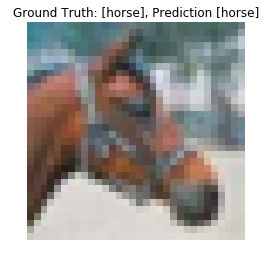

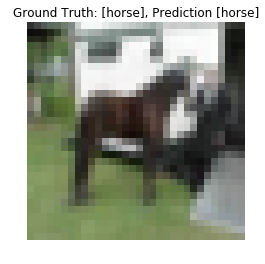

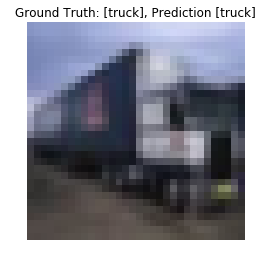

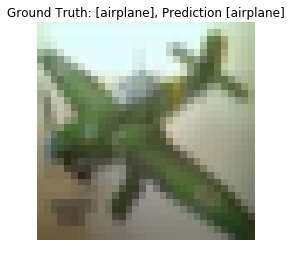

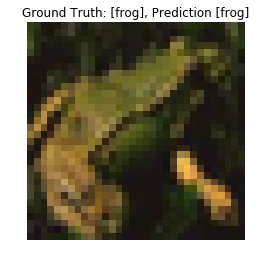

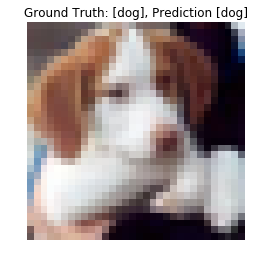

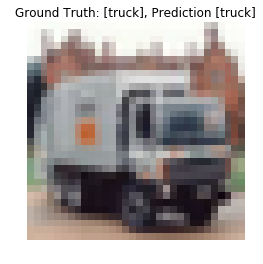

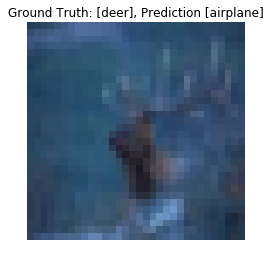

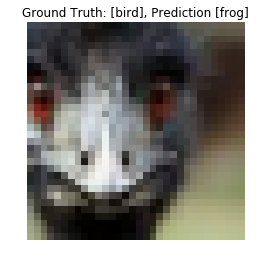

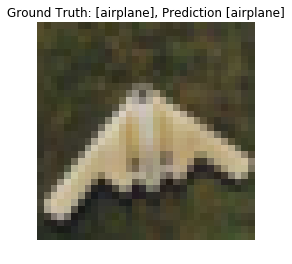

CPU times: user 3.46 s, sys: 3.66 s, total: 7.11 s
Wall time: 2.68 s


In [9]:
%%time
batch_size = 10
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = cifar10.get_split('test',cifar10_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    logits = cnn_relu(images, num_classes=dataset.num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.local_variables_initializer())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()